In [1]:
import time
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import scripts.helpers as helpers
from scipy.optimize import minimize, show_options, basinhopping, differential_evolution, brute

#### Empecemos por cargar los datos

In [2]:
path = "./data/data.xlsx"

In [3]:
df = helpers.dataframe(path)

In [4]:
firstyields = df[df.index == "2022-02-11"]

In [5]:
today = firstyields.index

In [6]:
today

DatetimeIndex(['2022-02-11'], dtype='datetime64[ns]', name='Date', freq=None)

#### Partimos de un vector de alphas (nuestra curva), creada al azar

In [7]:
alphas = (0.1,0.11,0.12,0.13,0.14)

#### Suponemos que: 
- $\alpha_1$ representa la tasa forward entre 0 y 3 meses, 
- $\alpha_2$ la tasa entre 3 meses y 1 año, 
- $\alpha_3$ la tasa entre 1 y 3 años,
- $\alpha_4$ la tasa entre 3 y 5 años ,
- $\alpha_5$ la tasa entre 5 y 10 años.

#### Ahora bien, para valorar un bono, se sigue que:

$$ \sum_{i=1}^{T} \frac{(C \% *100)}{{(1+y_i)}^{t_i}} + \frac {N}{{(1+y_i)}^{T}}$$ 

#### Además, para traer a valor presente usando una curva forward, se sigue el factor de descuento a un plazo T es: 

### $$ e^{-\int_{0}^{T} f(t) \,dt}$$

#### Con lo anterior, para valorar un bono para el taller, se sigue que:
$$ \sum_{i=1}^{T} (C \% *100)*e^{-\int_{0}^{T} f(t) \,dt} +  {N}*{e^{-\int_{0}^{T} f(t) \,dt}}$$ 

#### Así, para convertir las tasas anualizadas utilzaremos la siguiente función:

In [8]:
def rateconverter(rate, T, today):
    """
    Returns a converted interest rate, for a desired maturity.
    Parameters:
        rate: yearly interest rate
        T: maturity in months
        today: current date, expressed as a DateTimeIndex
    """
    days = (today[0].date()+relativedelta(months=T) - today[0].date()).days
    newrate = rate*days/360
    return round(newrate,decimals = 5)

#### Y para hallar los factores de descuento, asumiendo una curva constante a trozos:

In [9]:
def discountfactor(curve, T):
    """
    Returns the discount factor for a given maturity and forward curve, assuming a constant stepwise curve 
    Parameters:
        curve: forward curve
        T: maturity in months
    """
    intervals_r=[3,12,36,60,120]
    intervals_l=[0,3,12,36,60]
    mask = [(t<=T) for t in intervals_l]
    minimum = np.minimum(T, intervals_r)
    areas = ((minimum-intervals_l)/12)*curve*mask
    totalarea = np.sum(areas)
    print(totalarea)
    discountfactor = np.exp(-totalarea)
    return discountfactor

In [10]:
discountfactor(alphas, 12)

0.10750000000000001


0.8980765224508025

In [11]:
helpers.discountfactor(alphas, 6)

0.9488543210558013

In [12]:
tmb = 100 +helpers.rateconverter(firstyields["3M"][0], 3 , today)*helpers.discountfactor(alphas, 6)
tmb

100.08421345670016

#### Miremos cómo se comporta la función para el factor de descuento:

In [13]:
alphas = np.arange (0.1,0.6,.01)
maturities = np.arange(1,51,1)
discounts = list(map(helpers.discountfactor, alphas, maturities))

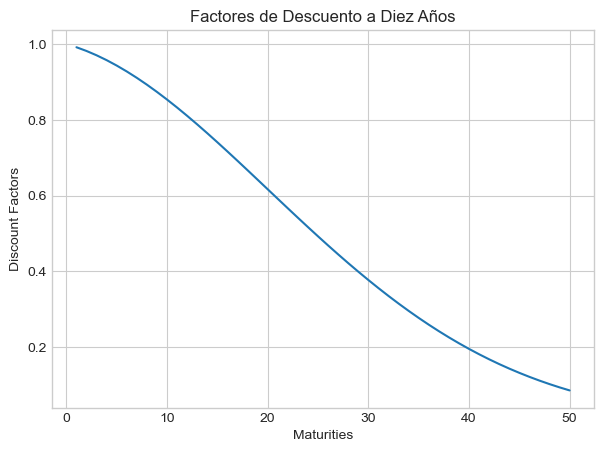

In [14]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.xlabel('Maturities')
plt.ylabel('Discount Factors')
plt.title('Factores de Descuento a Diez Años')
plt.plot(maturities,discounts)

#  <span style="color:red">Germán 1 Le pregunté a Diego, y me dijo que no era normal que para esos valores iniciales los factores de descuento dieran así, sobretodo tomando en cuenta que estoy metiendo alphas que crecen constante. </span> 
 

#### Ahora definamos la función de pagos para un bono específico:

In [15]:
alphas2 = [0.07853351, 0.08539753, 0.04942368, 0.08465615, 0.0079]

In [25]:
def singlebondpayment(T, rate, alpha, today):
    return helpers.rateconverter(rate, T, today)*helpers.discountfactor(alpha, T)

#### Generalizando para cualquier bono:

In [27]:
def bondvalue(today, T, rates, alpha):
    if T == 3:
        return singlebondpayment(3, rates["3M"][0], alpha, today) + 100*helpers.discountfactor(alpha , T)
    else:
        maturitynames = [i for i in rates.columns]
        maturitydates = [3,6,12,24,36,60,84,120]
        maturitydict = {maturitydates[i]: maturitynames[i] for i in range(len(maturitynames))}
        periods = np.arange(6,T+6,6)
        bondpayments= np.array([singlebondpayment(i, rate = rates[maturitydict[T]][0], today = today, alpha = alphas) for i in periods])
        sumpayments = np.sum(bondpayments) 
        return sumpayments + 100*helpers.discountfactor(alpha, T)

#### Definamos el error como la diferencia de los cuadrados

In [29]:
def error(alpha):
    maturitydates = [3,6,12,24,36,60,84,120]
    bondvalues = [bondvalue(today, i, firstyields, alpha) for i in maturitydates]
    errorval= np.sum(np.square(np.subtract(100,bondvalues)))
    return errorval

#### Podemos minimizar esta función con respecto a los parámetros 

In [31]:
func = 10000000
a = []
for i in range(100):
    alphas = np.random.uniform(low = 0.1, high = 0.3, size = 5)
    res = minimize(error, alphas, bounds = ((0,.3),(0,.3),(0,.3),(0,.3),(0,.3)))
    if res.fun < func:
        func = res.fun
        a.append(np.array(alphas))
        print(func, alphas)
    else:
        continue

236.09795088496153 [0.1881746  0.12888353 0.10608345 0.24757428 0.185098  ]
74.10906926720534 [0.22533779 0.16398923 0.23809723 0.26740403 0.26589932]
51.671173757323636 [0.18163774 0.26130462 0.13027394 0.22879886 0.25596779]
28.426234712228094 [0.14118276 0.28244432 0.25382246 0.23638375 0.21894035]
25.73432289072914 [0.12913949 0.29502434 0.2645453  0.22789019 0.25763544]
6.966273380398602 [0.19503805 0.11723083 0.18029748 0.25845339 0.12911189]
5.367036809215258 [0.22615293 0.21719166 0.24545236 0.23305941 0.13733982]
5.346426663420709 [0.2756761  0.17487172 0.26733164 0.29260373 0.12291427]


#  <span style="color:red">Germán 2 De aquí me genera muchas dudas que cambiando el vector inicial de alphas cambie tanto el mínimo que encuentra el optimizador</span> 


In [32]:
alpha1 = []
alpha2 =[]
alpha3 =[]
alpha4=[]
alpha5=[]
for i in a:
    alpha1.append(i[0])
    alpha2.append(i[1])
    alpha3.append(i[2])
    alpha4.append(i[3])
    alpha5.append(i[4])

Text(0.5, 1.0, 'Alpha Vol')

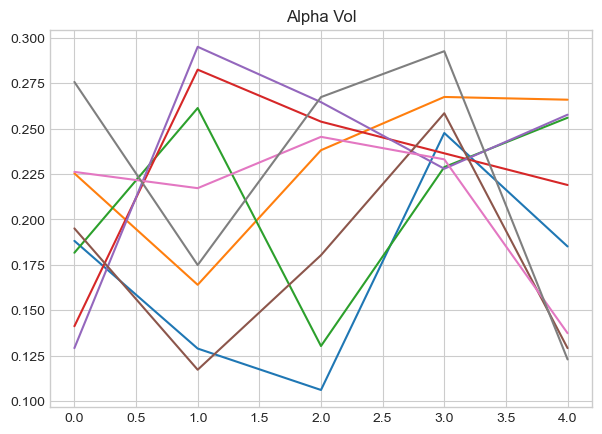

In [33]:
plt.plot([alpha1,alpha2, alpha3, alpha4,alpha5])
plt.title("Alpha Vol")

In [ ]:
iterating_alphas = a

In [25]:
alphas = [0.00343939424789704, 0.0105322205923502, 0.0817121232717679, 0.159800322624318, 0.274481567907549]

#### Usemos estos valores para calcular el valor del cupón que valora a par

In [ ]:
# Sabemos que para valorar a par, el valor final del bono debe ser 100, y esto a su vez debe equivaler a la suma de los bonos traidos a valor presente más el nocional que se paga en el último periodo también traido a valor presente
100 = helpers.discountfactor(alphas[2], 12)*helpers.rateconverter(c,12,today) + helpers.discountfactor(alphas[2], 24)*helpers.rateconverter(c,24,today) +
helpers.discountfactor(alphas[3], 36)*helpers.rateconverter(c,36,today) +helpers.discountfactor(alphas[3], 48)*helpers.rateconverter(c,48,today) +
helpers.discountfactor(alphas[4], 60)*helpers.rateconverter(c,60,today)+helpers.discountfactor(alphas[4], 72)*helpers.rateconverter(c,72,today) + 
helpers.discountfactor(alphas[4], 84)*helpers.rateconverter(c,84,today) + helpers.discountfactor(alphas[4], 84)*100

In [27]:
# Traigamos a valor presente el pago del nocional
pvnotional = helpers.discountfactor(alphas[4], 84)*100

In [28]:
# Restando del valor original, obtenemos que la suma de los cupones traidos a valor presente es:
totalcoupons = 100-pvnotional
print(totalcoupons)

85.35938946849538


#### Iterando sobre algunos valores de C obtenemos que el valor de C que satisface la valoración a par del bono es:

#  <span style="color:red">Germán 3 Con esos alphas obtuve un C muy alto, y Diego dice que está mal</span> 

In [29]:
c = 8.3840515175172702

In [30]:
couponsum =\
  helpers.discountfactor(alphas[2], 12)*helpers.rateconverter(c,12,today) \
+ helpers.discountfactor(alphas[2], 24)*helpers.rateconverter(c,24,today)\
+ helpers.discountfactor(alphas[3], 36)*helpers.rateconverter(c,36,today)\
+ helpers.discountfactor(alphas[3], 48)*helpers.rateconverter(c,48,today)\
+ helpers.discountfactor(alphas[4], 60)*helpers.rateconverter(c,60,today)\
+ helpers.discountfactor(alphas[4], 72)*helpers.rateconverter(c,72,today)\
+ helpers.discountfactor(alphas[4], 84)*helpers.rateconverter(c,84,today)

In [31]:
np.around(couponsum - totalcoupons, 13) ## La diferencia es 0 hasta la 13a cifra significativa

-0.0

#### Calibración de curvas del último año

In [91]:
lastyear = df.sort_index().loc['2021-02-04':'2022-02-04']

In [98]:
try1

,10Y,7Y,5Y,3Y,2Y,1Y,6M,3M
Date,,,,,,,,
2021-02-05,1.165,0.819,0.463,0.178,0.104,0.060,0.044,0.025
2021-02-12,1.211,0.847,0.492,0.196,0.111,0.065,0.053,0.039
2021-02-19,1.339,0.972,0.577,0.209,0.108,0.051,0.039,0.029


In [92]:
try1 = lastyear.loc['2021-02-05':'2021-02-19']

In [104]:
alpha_mat = []
alphas = (0.1,0.11,0.12,0.13,0.14)
for label, content in try1.iteritems():
    currentyields = label
    today = content
    print(today)
    maturitydates = [3,6,12,24,36,60,84,120]
    #print(row)
    #bondvalues = [bondvalue(today, i, currentyields, alphas) for i in maturitydates]
    #print(bondvalues)
    #errorval= np.sum(np.square(np.subtract(100,bondvalues)))
    

Date
2021-02-05    1.165
2021-02-12    1.211
2021-02-19    1.339
Name: 10Y, dtype: float64
Date
2021-02-05    0.819
2021-02-12    0.847
2021-02-19    0.972
Name: 7Y, dtype: float64
Date
2021-02-05    0.463
2021-02-12    0.492
2021-02-19    0.577
Name: 5Y, dtype: float64
Date
2021-02-05    0.178
2021-02-12    0.196
2021-02-19    0.209
Name: 3Y, dtype: float64
Date
2021-02-05    0.104
2021-02-12    0.111
2021-02-19    0.108
Name: 2Y, dtype: float64
Date
2021-02-05    0.060
2021-02-12    0.065
2021-02-19    0.051
Name: 1Y, dtype: float64
Date
2021-02-05    0.044
2021-02-12    0.053
2021-02-19    0.039
Name: 6M, dtype: float64
Date
2021-02-05    0.025
2021-02-12    0.039
2021-02-19    0.029
Name: 3M, dtype: float64
